In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import joblib

# Needed for API key
from dotenv import load_dotenv
import os
import requests

In [2]:
stock = 'GME'
load_dotenv()
key = os.getenv('key')

In [3]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={key}'
r = requests.get(url)
data = r.json()

In [4]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GME',
 '3. Last Refreshed': '2025-06-09',
 '4. Output Size': 'Compact',
 '5. Time Zone': 'US/Eastern'}

In [5]:
gme_data = data['Time Series (Daily)']

In [6]:
df = pd.DataFrame.from_dict(gme_data, orient = 'index')
df.index = pd.to_datetime(df.index)
df = df.astype(float)
df = df.sort_index()
df

,1. open,2. high,3. low,4. close,5. volume
2025-01-15,28.90,29.3300,27.84,27.96,6025350.0
2025-01-16,27.94,28.1400,27.41,27.72,4431995.0
2025-01-17,27.61,28.7899,27.02,27.51,8977526.0
2025-01-21,27.40,27.5700,26.33,27.47,5867780.0
2025-01-22,27.36,28.0160,27.30,27.65,5025385.0
...,...,...,...,...,...
2025-06-03,30.81,31.0500,30.02,30.10,6086532.0
2025-06-04,29.90,30.9700,29.34,29.95,7313977.0
2025-06-05,29.81,30.6080,29.23,29.45,6356776.0
2025-06-06,29.68,30.0000,29.52,29.58,4379288.0


In [7]:
# get rid of 1s and 2s in front of column names
df.columns = df.columns.str.replace(r"^\d+\.\s*", "", regex=True)

In [8]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [9]:
df.shape

(100, 5)

In [10]:
df.groupby(df.index.date).size()

2025-01-15    1
2025-01-16    1
2025-01-17    1
2025-01-21    1
2025-01-22    1
             ..
2025-06-03    1
2025-06-04    1
2025-06-05    1
2025-06-06    1
2025-06-09    1
Length: 100, dtype: int64

In [11]:
start_date = df.index.min().date().strftime('%Y%m%d')
end_date = df.index.max().date().strftime('%Y%m%d')

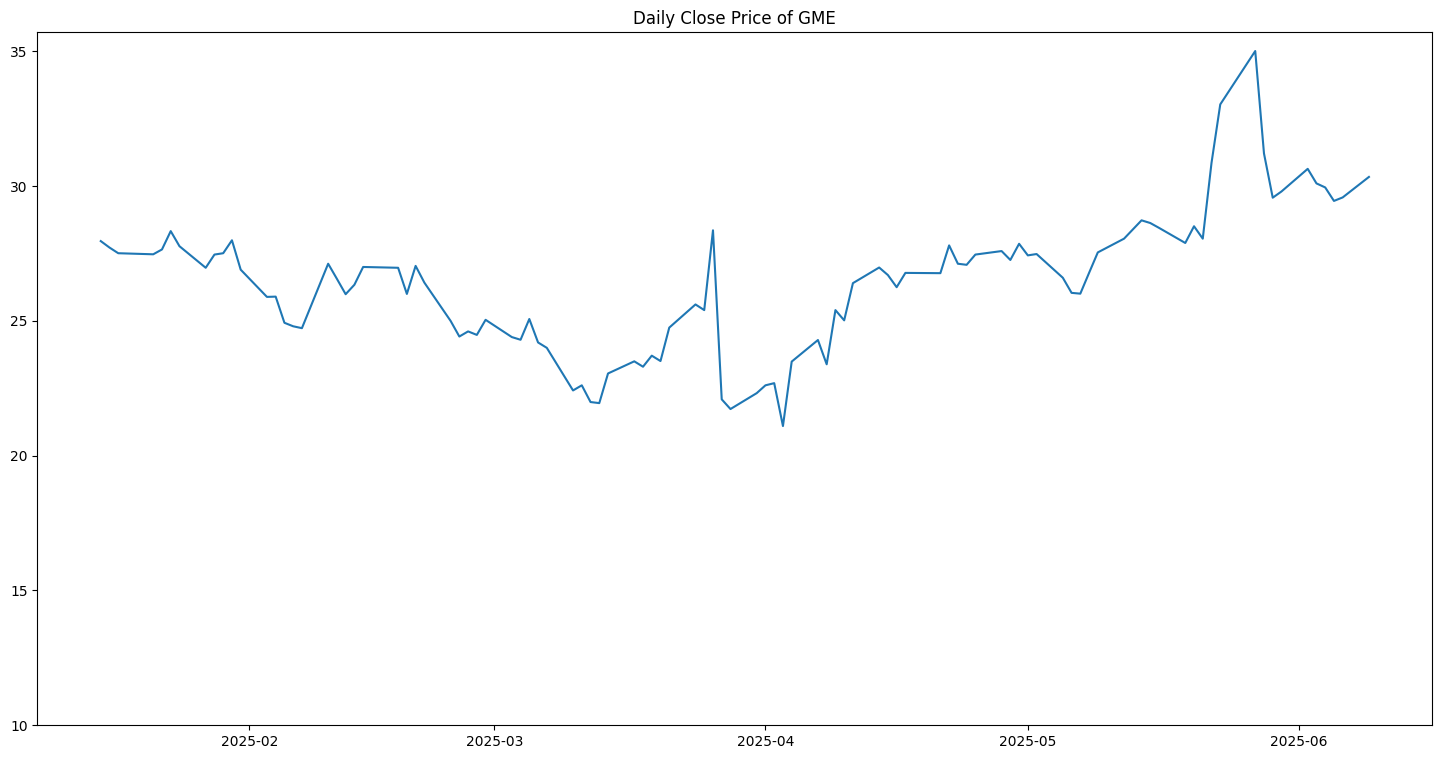

In [12]:
plt.figure(figsize = (18,9))
plt.plot(df['close'])
plt.title('Daily Close Price of GME')
plt.yticks(range(10,40,5));

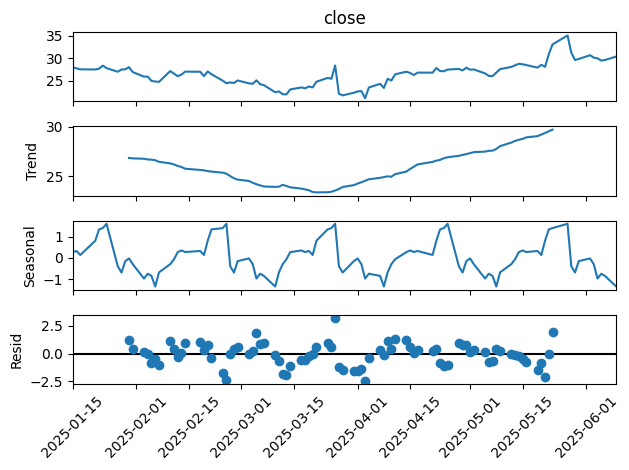

In [13]:
decomp = seasonal_decompose(df['close'],model='additive', period = 21)
fig = decomp.plot()

# Rotate only the Resid x-axis 45 degrees so it is legible
resid_ax = fig.axes[-1]
for label in resid_ax.get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

# Get in News

In [14]:
news_url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={stock}&time_from={start_date}T0000&time_to={end_date}T0000&apikey={key}'
r = requests.get(news_url)
data = r.json()

In [15]:
feed_items = data['feed']

In [16]:
feed_items

[{'title': "3 Reasons to Buy Floor & Decor Stock Like There's No Tomorrow",
  'url': 'https://www.fool.com/investing/2025/06/08/3-reasons-to-buy-floor-decor-stock-like-theres-no/',
  'time_published': '20250608T191400',
  'authors': ['Jon Quast'],
  'summary': 'In 2017, home improvement retail chain Floor & Decor Holdings ( NYSE: FND ) went public. It only had about 70 locations and was still virtually unknown. And investors could have bought it at any time during the past eight years.',
  'banner_image': 'https://g.foolcdn.com/image/?url=https%3A%2F%2Fg.foolcdn.com%2Feditorial%2Fimages%2F819829%2Fa-man-installs-plank-flooring.jpg&op=resize&w=700',
  'source': 'Motley Fool',
  'category_within_source': 'n/a',
  'source_domain': 'www.fool.com',
  'topics': [{'topic': 'IPO', 'relevance_score': '0.158519'},
   {'topic': 'Retail & Wholesale', 'relevance_score': '1.0'},
   {'topic': 'Financial Markets', 'relevance_score': '0.503496'},
   {'topic': 'Earnings', 'relevance_score': '0.650727'}]

In [17]:
flat_data = []

for article in feed_items:
    base = {
        'title': article.get('title'),
        'time_published': article.get('time_published'),
        'authors': ", ".join(article.get('authors', [])),
        'summary': article.get('summary'),
        'source': article.get('source'),
        'overall_sentiment_score': article.get('overall_sentiment_score'),
        'overall_sentiment_label': article.get('overall_sentiment_label'),
    }

    # Topics as comma-separated string
    topics = article.get('topics', [])
    topic_names = [t['topic'] for t in topics]
    base['topics'] = ", ".join(topic_names)

    # Ticker sentiment - multiple tickers possible, so one row per ticker
    for ticker_info in article.get('ticker_sentiment', []):
        if ticker_info.get('ticker') == stock:
            base['ticker'] = ticker_info.get('ticker')
            base['ticker_relevance_score'] = ticker_info.get('relevance_score')
            base['ticker_sentiment_score'] = ticker_info.get('ticker_sentiment_score')
            base['ticker_sentiment_label'] = ticker_info.get('ticker_sentiment_label')
            flat_data.append(base)
            break

news = pd.DataFrame(flat_data)

In [18]:
news

,title,time_published,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
0,3 Reasons to Buy Floor & Decor Stock Like Ther...,20250608T191400,Jon Quast,"In 2017, home improvement retail chain Floor &...",Motley Fool,0.348805,Somewhat-Bullish,"IPO, Retail & Wholesale, Financial Markets, Ea...",GME,0.053271,0.0,Neutral
1,Here's Why GameStop Stock Is Plunging,20250607T081200,Adria Cimino,Share price volatility isn't new territory for...,Motley Fool,0.027263,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.659686,0.079873,Neutral
2,Jim Cramer's week ahead: Consumer price index ...,20250606T223657,,The 'Mad Money' host walked investors through ...,CNBC,0.208792,Somewhat-Bullish,"Technology, Blockchain, Economy - Monetary, IP...",GME,0.055492,0.035009,Neutral
3,"Bitcoin rebounds to $105K, but is a 'bull trap...",20250606T152000,Marcel Pechman,Market uncertainty grows as traders question l...,Cointelegraph,-0.221813,Somewhat-Bearish,"Economy - Monetary, Life Sciences, Retail & Wh...",GME,0.063425,-0.024127,Neutral
4,Here's Why GameStop ( GME ) Fell More Than B...,20250605T214516,Zacks Equity Research,GameStop (GME) reachead $29.45 at the closing ...,Zacks Commentary,0.135615,Neutral,"Earnings, Retail & Wholesale, Financial Markets",GME,0.509589,0.079995,Neutral
5,GameStop Shares Are Volatile Ahead Of Earnings...,20250605T185821,Henry Khederian,GameStop shares climbed with Nintendo Switch 2...,Benzinga,0.349688,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.533842,0.498937,Bullish
6,"Bitcoin At $105,000: Bull Market Correction Or...",20250605T121719,Murtuza J Merchant,Corporate inventories stagnated while core cap...,Benzinga,0.029735,Neutral,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.142565,0.0,Neutral
7,Healthcare Tech Company Semler Buys More Bitco...,20250604T150909,"Mat Di Salvo, André Beganski",The Nasdaq-listed healthcare technology firm h...,Decrypt.co,0.176618,Somewhat-Bullish,"Life Sciences, Retail & Wholesale, Financial M...",GME,0.126119,0.158907,Somewhat-Bullish
8,"Metaplanet Grows Bitcoin Treasury to 8,888 BTC...",20250602T153348,Simon Chandler,Metaplane revealed that in the past 12 months ...,Decrypt.co,0.229969,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.104002,0.172542,Somewhat-Bullish
9,Should GameStop Stock Be in Your Portfolio Pre...,20250602T153200,Swagata Bhattacharya,GME's Q1 results are likely to reflect y/y EPS...,Zacks Commentary,0.236484,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Earning...",GME,0.573417,0.325407,Somewhat-Bullish


In [19]:
news.isnull().sum()

title                      0
time_published             0
authors                    0
summary                    0
source                     0
overall_sentiment_score    0
overall_sentiment_label    0
topics                     0
ticker                     0
ticker_relevance_score     0
ticker_sentiment_score     0
ticker_sentiment_label     0
dtype: int64

In [20]:
news.shape

(50, 12)

In [21]:
news['authors'].unique()

array(['Jon Quast', 'Adria Cimino', '', 'Marcel Pechman',
       'Zacks Equity Research', 'Henry Khederian', 'Murtuza J Merchant',
       'Mat Di Salvo, André Beganski', 'Simon Chandler',
       'Swagata Bhattacharya', 'Brayden Lindrea', 'Andrew Hayward',
       'Liz Napolitano', 'Benzinga Insights', 'Stacy Elliott',
       'Aniket Verma', 'Surbhi Jain', 'Dan DeFrancesco', 'Amin Haqshanas',
       'Stephen Katte', 'Vince Quill', 'Mahak Lohia', 'Akanksha Bakshi',
       'Helen Partz', 'Ryan S. Gladwin', 'Shivdeep Dhaliwal',
       'Logan Hitchcock', 'Vaishali Prayag', 'Jason Nelson',
       'Vishaal Sanjay', 'Bram Berkowitz', 'Benzinga Research Team',
       'Alex O’Donnell', 'Rishabh Mishra'], dtype=object)

In [22]:
news['time_published'] = news['time_published'].str[:8]
news['time_published'] = pd.to_datetime(news['time_published'], format = '%Y%m%d')
news = news.set_index('time_published')

In [23]:
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-06-08,3 Reasons to Buy Floor & Decor Stock Like Ther...,Jon Quast,"In 2017, home improvement retail chain Floor &...",Motley Fool,0.348805,Somewhat-Bullish,"IPO, Retail & Wholesale, Financial Markets, Ea...",GME,0.053271,0.0,Neutral
2025-06-07,Here's Why GameStop Stock Is Plunging,Adria Cimino,Share price volatility isn't new territory for...,Motley Fool,0.027263,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.659686,0.079873,Neutral
2025-06-06,Jim Cramer's week ahead: Consumer price index ...,,The 'Mad Money' host walked investors through ...,CNBC,0.208792,Somewhat-Bullish,"Technology, Blockchain, Economy - Monetary, IP...",GME,0.055492,0.035009,Neutral
2025-06-06,"Bitcoin rebounds to $105K, but is a 'bull trap...",Marcel Pechman,Market uncertainty grows as traders question l...,Cointelegraph,-0.221813,Somewhat-Bearish,"Economy - Monetary, Life Sciences, Retail & Wh...",GME,0.063425,-0.024127,Neutral
2025-06-05,Here's Why GameStop ( GME ) Fell More Than B...,Zacks Equity Research,GameStop (GME) reachead $29.45 at the closing ...,Zacks Commentary,0.135615,Neutral,"Earnings, Retail & Wholesale, Financial Markets",GME,0.509589,0.079995,Neutral
2025-06-05,GameStop Shares Are Volatile Ahead Of Earnings...,Henry Khederian,GameStop shares climbed with Nintendo Switch 2...,Benzinga,0.349688,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.533842,0.498937,Bullish
2025-06-05,"Bitcoin At $105,000: Bull Market Correction Or...",Murtuza J Merchant,Corporate inventories stagnated while core cap...,Benzinga,0.029735,Neutral,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.142565,0.0,Neutral
2025-06-04,Healthcare Tech Company Semler Buys More Bitco...,"Mat Di Salvo, André Beganski",The Nasdaq-listed healthcare technology firm h...,Decrypt.co,0.176618,Somewhat-Bullish,"Life Sciences, Retail & Wholesale, Financial M...",GME,0.126119,0.158907,Somewhat-Bullish
2025-06-02,"Metaplanet Grows Bitcoin Treasury to 8,888 BTC...",Simon Chandler,Metaplane revealed that in the past 12 months ...,Decrypt.co,0.229969,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.104002,0.172542,Somewhat-Bullish


In [24]:
news.groupby(news.index.date).size()

2025-05-16    6
2025-05-19    4
2025-05-20    2
2025-05-22    2
2025-05-23    2
2025-05-26    1
2025-05-27    3
2025-05-28    8
2025-05-29    5
2025-05-30    4
2025-05-31    1
2025-06-01    1
2025-06-02    3
2025-06-04    1
2025-06-05    3
2025-06-06    2
2025-06-07    1
2025-06-08    1
dtype: int64

In [25]:
news[news['authors'] == '']

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-06-06,Jim Cramer's week ahead: Consumer price index ...,,The 'Mad Money' host walked investors through ...,CNBC,0.208792,Somewhat-Bullish,"Technology, Blockchain, Economy - Monetary, IP...",GME,0.055492,0.035009,Neutral
2025-05-28,GameStop shares rise as retailer meme stock bu...,,"The purchase, GameStop's first investment in b...",CNBC,0.111642,Neutral,"Economy - Fiscal, Retail & Wholesale, Financia...",GME,0.546745,0.280448,Somewhat-Bullish


In [26]:
news.loc[news['authors'] == '', 'authors'] = 'Unknown Author'
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-06-08,3 Reasons to Buy Floor & Decor Stock Like Ther...,Jon Quast,"In 2017, home improvement retail chain Floor &...",Motley Fool,0.348805,Somewhat-Bullish,"IPO, Retail & Wholesale, Financial Markets, Ea...",GME,0.053271,0.0,Neutral
2025-06-07,Here's Why GameStop Stock Is Plunging,Adria Cimino,Share price volatility isn't new territory for...,Motley Fool,0.027263,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.659686,0.079873,Neutral
2025-06-06,Jim Cramer's week ahead: Consumer price index ...,Unknown Author,The 'Mad Money' host walked investors through ...,CNBC,0.208792,Somewhat-Bullish,"Technology, Blockchain, Economy - Monetary, IP...",GME,0.055492,0.035009,Neutral
2025-06-06,"Bitcoin rebounds to $105K, but is a 'bull trap...",Marcel Pechman,Market uncertainty grows as traders question l...,Cointelegraph,-0.221813,Somewhat-Bearish,"Economy - Monetary, Life Sciences, Retail & Wh...",GME,0.063425,-0.024127,Neutral
2025-06-05,Here's Why GameStop ( GME ) Fell More Than B...,Zacks Equity Research,GameStop (GME) reachead $29.45 at the closing ...,Zacks Commentary,0.135615,Neutral,"Earnings, Retail & Wholesale, Financial Markets",GME,0.509589,0.079995,Neutral
2025-06-05,GameStop Shares Are Volatile Ahead Of Earnings...,Henry Khederian,GameStop shares climbed with Nintendo Switch 2...,Benzinga,0.349688,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.533842,0.498937,Bullish
2025-06-05,"Bitcoin At $105,000: Bull Market Correction Or...",Murtuza J Merchant,Corporate inventories stagnated while core cap...,Benzinga,0.029735,Neutral,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.142565,0.0,Neutral
2025-06-04,Healthcare Tech Company Semler Buys More Bitco...,"Mat Di Salvo, André Beganski",The Nasdaq-listed healthcare technology firm h...,Decrypt.co,0.176618,Somewhat-Bullish,"Life Sciences, Retail & Wholesale, Financial M...",GME,0.126119,0.158907,Somewhat-Bullish
2025-06-02,"Metaplanet Grows Bitcoin Treasury to 8,888 BTC...",Simon Chandler,Metaplane revealed that in the past 12 months ...,Decrypt.co,0.229969,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.104002,0.172542,Somewhat-Bullish


In [27]:
news['overall_sentiment_label'].unique()

array(['Somewhat-Bullish', 'Neutral', 'Somewhat-Bearish', 'Bullish'],
      dtype=object)

In [28]:
news['ticker_sentiment_label'].unique()

array(['Neutral', 'Bullish', 'Somewhat-Bullish'], dtype=object)

In [29]:
news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})
news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})

C:\Users\graha\AppData\Local\Temp\ipykernel_10412\3453675565.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
C:\Users\graha\AppData\Local\Temp\ipykernel_10412\3453675565.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({


# Merge both DataFrames

In [30]:
merged_df = df.merge(news,how = 'left',left_index = True, right_index = True)
merged_df = merged_df.fillna(0)
merged_df

,open,high,low,close,volume,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2025-01-15,28.90,29.3300,27.84,27.96,6025350.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2025-01-16,27.94,28.1400,27.41,27.72,4431995.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2025-01-17,27.61,28.7899,27.02,27.51,8977526.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2025-01-21,27.40,27.5700,26.33,27.47,5867780.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2025-01-22,27.36,28.0160,27.30,27.65,5025385.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-05,29.81,30.6080,29.23,29.45,6356776.0,GameStop Shares Are Volatile Ahead Of Earnings...,Henry Khederian,GameStop shares climbed with Nintendo Switch 2...,Benzinga,0.349688,4.0,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.533842,0.498937,5.0
2025-06-05,29.81,30.6080,29.23,29.45,6356776.0,"Bitcoin At $105,000: Bull Market Correction Or...",Murtuza J Merchant,Corporate inventories stagnated while core cap...,Benzinga,0.029735,3.0,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.142565,0.0,3.0
2025-06-06,29.68,30.0000,29.52,29.58,4379288.0,Jim Cramer's week ahead: Consumer price index ...,Unknown Author,The 'Mad Money' host walked investors through ...,CNBC,0.208792,4.0,"Technology, Blockchain, Economy - Monetary, IP...",GME,0.055492,0.035009,3.0
2025-06-06,29.68,30.0000,29.52,29.58,4379288.0,"Bitcoin rebounds to $105K, but is a 'bull trap...",Marcel Pechman,Market uncertainty grows as traders question l...,Cointelegraph,-0.221813,2.0,"Economy - Monetary, Life Sciences, Retail & Wh...",GME,0.063425,-0.024127,3.0


In [31]:
merged_df.dtypes

open                       float64
high                       float64
low                        float64
close                      float64
volume                     float64
title                       object
authors                     object
summary                     object
source                      object
overall_sentiment_score    float64
overall_sentiment_label    float64
topics                      object
ticker                      object
ticker_relevance_score      object
ticker_sentiment_score      object
ticker_sentiment_label     float64
dtype: object

In [32]:
merged_df['ticker_relevance_score'] = merged_df['ticker_relevance_score'].astype(float)
merged_df['ticker_sentiment_score'] = merged_df['ticker_sentiment_score'].astype(float)

In [33]:
merged_df = merged_df.drop(columns = ['title','topics','ticker','authors','summary','source'])
merged_df

,open,high,low,close,volume,overall_sentiment_score,overall_sentiment_label,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2025-01-15,28.90,29.3300,27.84,27.96,6025350.0,0.000000,0.0,0.000000,0.000000,0.0
2025-01-16,27.94,28.1400,27.41,27.72,4431995.0,0.000000,0.0,0.000000,0.000000,0.0
2025-01-17,27.61,28.7899,27.02,27.51,8977526.0,0.000000,0.0,0.000000,0.000000,0.0
2025-01-21,27.40,27.5700,26.33,27.47,5867780.0,0.000000,0.0,0.000000,0.000000,0.0
2025-01-22,27.36,28.0160,27.30,27.65,5025385.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-06-05,29.81,30.6080,29.23,29.45,6356776.0,0.349688,4.0,0.533842,0.498937,5.0
2025-06-05,29.81,30.6080,29.23,29.45,6356776.0,0.029735,3.0,0.142565,0.000000,3.0
2025-06-06,29.68,30.0000,29.52,29.58,4379288.0,0.208792,4.0,0.055492,0.035009,3.0
2025-06-06,29.68,30.0000,29.52,29.58,4379288.0,-0.221813,2.0,0.063425,-0.024127,3.0


## LSTM Model

In [34]:
# Split off target
features = merged_df.drop(columns=['close'])
target = merged_df[['close']]

# Normalize
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target)

# Reassemble DataFrame
scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
scaled_df['close'] = target_scaled

In [35]:
def create_lstm_dataset(data, target_column, look_back):
    """
    Convert a dataframe into LSTM-compatible 3D sequences for a specific target column.
    
    Parameters:
    - data: pandas DataFrame (rows = time, cols = features)
    - target_column: name of the column to predict (e.g., 'Close')
    - look_back: number of past time steps to include

    Returns:
    - X: shape (num_samples, look_back, num_features)
    - y: shape (num_samples,)
    """
    # Extract features and target column
    features = data.drop(columns=[target_column]).values  # All columns except target
    target = data[target_column].values  # Target column
    
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(features[i:i+look_back])  # Look-back window of features
        y.append(target[i + look_back])  # Next time-step's target value
        
    return np.array(X), np.array(y)
look_back = 10
X_all, y_all = create_lstm_dataset(scaled_df, target_column='close', look_back=look_back)

# Use all data except the final 14 days (7 for evaluation + 7 for prediction)
test_days = 7
eval_days = 7
X_train = X_all[:- (test_days + eval_days)]
y_train = y_all[:- (test_days + eval_days)]

X_eval = X_all[-(test_days + eval_days):-test_days]
y_eval = y_all[-(test_days + eval_days):-test_days]

In [36]:
# Define the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

C:\Users\graha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
early_stop = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,          # Stop after 10 epochs with no improvement
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # Needed for val_loss monitoring
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0870 - val_loss: 0.2124
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0283 - val_loss: 0.0618
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0197 - val_loss: 0.0440
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0143 - val_loss: 0.0378
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0160 - val_loss: 0.0514
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0125 - val_loss: 0.0540
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0141 - val_loss: 0.0377
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0100 - val_loss: 0.0417
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0127 - val_loss: 0.0372
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0115 - val_loss: 0.0363
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0106 - val_loss: 0.0354
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0103 - val_l

In [38]:
y_eval_pred = model.predict(X_eval)
y_eval_pred_unscaled = target_scaler.inverse_transform(y_eval_pred)
y_eval_actual_unscaled = target_scaler.inverse_transform(y_eval.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


In [39]:
last_window = scaled_df.drop(columns=['close']).values[-look_back:]

future_predictions_scaled = []
input_seq = last_window.copy()

for _ in range(7):  # Predict 7 days
    pred = model.predict(input_seq[np.newaxis, :, :])[0, 0]
    future_predictions_scaled.append(pred)

    # Append the prediction to the feature window (use previous features and predicted close)
    next_features = np.append(input_seq[-1, :-1], pred)  # Replace last 'close'
    input_seq = np.vstack([input_seq[1:], next_features])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [40]:
# Unscale predictions
future_preds_unscaled = target_scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

In [41]:
# Get the last available date in your dataset
last_known_date = merged_df.index[-1]

# Generate next 7 business days after last known stock price date
future_dates = pd.bdate_range(start=last_known_date + pd.Timedelta(days=1), periods=7)

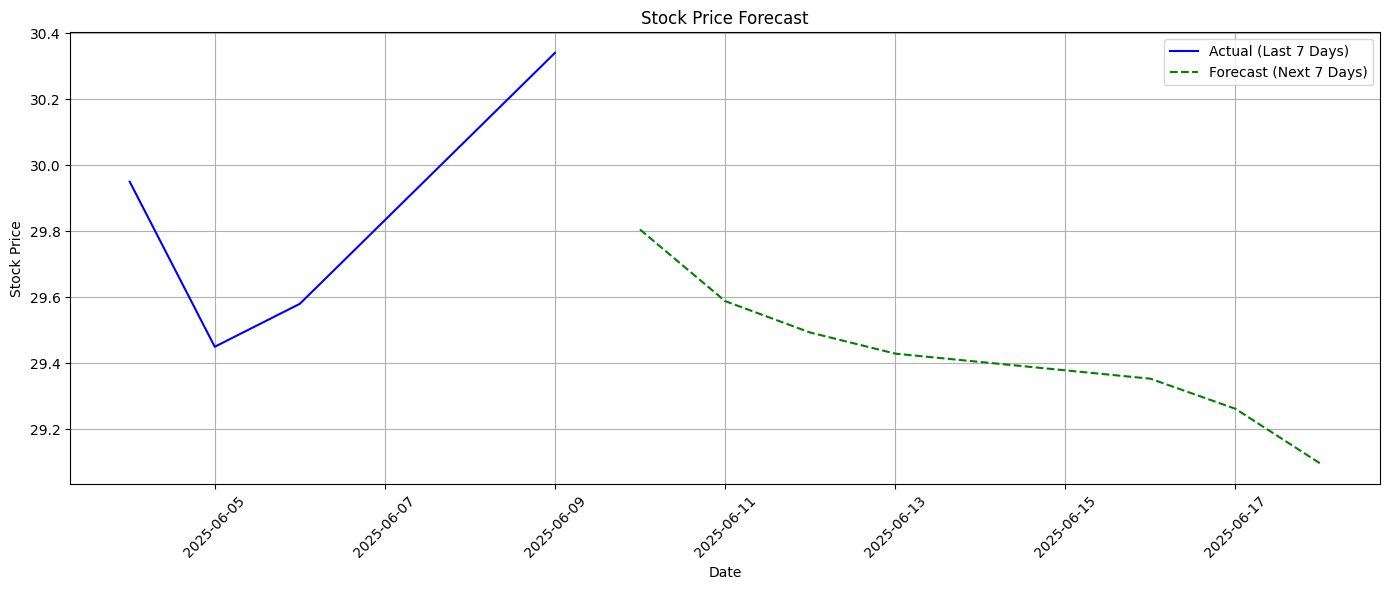

In [42]:
plt.figure(figsize=(14, 6))

# Plot actual stock prices for the last N days (e.g., last 7)
plt.plot(merged_df.index[-7:], merged_df['close'].values[-7:], label="Actual (Last 7 Days)", color="blue")

# Plot predicted prices for the next 7 business days
plt.plot(future_dates, future_preds_unscaled, label="Forecast (Next 7 Days)", color="green", linestyle='--')

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Forecast")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Random Forest Model

In [67]:
df= merged_df.copy()

df['target'] = df['close'].shift(-7)
df = df.dropna()

X = df.drop(columns=['target'])
y = df['target']

In [68]:
pipe = Pipeline([
    ('scaler', StandardScaler()),     
    ('rf',     RandomForestRegressor(random_state=42))
])

In [69]:
tscv = TimeSeriesSplit(n_splits=5)

In [70]:
param_dist = {
    'rf__n_estimators':      np.arange(100, 1000),
    'rf__max_depth':         [None] + list(np.arange(5, 51)),
    'rf__min_samples_split': np.arange(2,51),
    'rf__min_samples_leaf':  np.arange(1,11)
}

random_search = RandomizedSearchCV(
    estimator = pipe,
    param_distributions = param_dist,
    n_iter = 300,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    verbose = 2,
    n_jobs = -1,
    random_state = 42
)

random_search.fit(X, y)

print("Best RMSE (random search):", -random_search.best_score_)
print("Best params (random search):", random_search.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best RMSE (random search): 2.492502347997386
Best params (random search): {'rf__n_estimators': 747, 'rf__min_samples_split': 12, 'rf__min_samples_leaf': 5, 'rf__max_depth': 16}


In [71]:
best_params = random_search.best_params_

param_grid = {
    'rf__n_estimators': [best_params['rf__n_estimators'] - 100,
                         best_params['rf__n_estimators'],
                         best_params['rf__n_estimators'] + 100],
    'rf__max_depth': [best_params['rf__max_depth'] - 5 if best_params['rf__max_depth'] else None,
                      best_params['rf__max_depth'],
                      best_params['rf__max_depth'] + 5 if best_params['rf__max_depth'] else None],
    'rf__min_samples_split': [best_params['rf__min_samples_split']],
    'rf__min_samples_leaf':  [best_params['rf__min_samples_leaf']]
}

# Clean None-related values
param_grid['rf__max_depth'] = [x for x in param_grid['rf__max_depth'] if x is not None]

grid_search = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    verbose = 2,
    n_jobs = -1
)

grid_search.fit(X, y)

print("Best RMSE (grid search):", -grid_search.best_score_)
print("Best params (grid search):", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best RMSE (grid search): 2.4872696859557477
Best params (grid search): {'rf__max_depth': 11, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 12, 'rf__n_estimators': 647}


In [73]:
y_pred = grid_search.predict(X)
pred_series = pd.Series(y_pred, index=X.index)

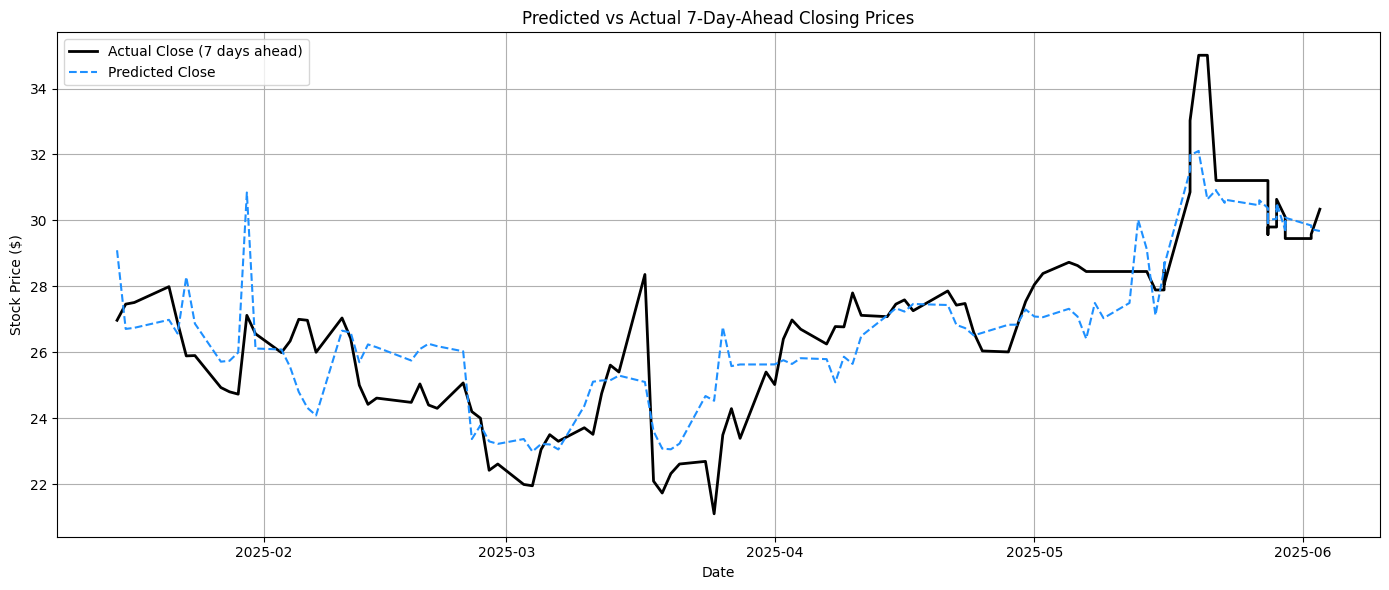

In [74]:
plt.figure(figsize=(14, 6))
plt.plot(y.index, y, label='Actual Close (7 days ahead)', color='black', linewidth=2)
plt.plot(pred_series.index, pred_series, label='Predicted Close', color='dodgerblue', linestyle='--')
plt.title('Predicted vs Actual 7-Day-Ahead Closing Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
joblib.dump(random_search.best_estimator_, "models/best_rf_model.pkl")

['best_rf_model.pkl']